In [1]:
from __future__ import absolute_import, division, print_function

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
import json
import pandas as pd
import numpy as np
import calendar
import time as t
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import urllib
import copy
from xml.etree import cElementTree as ET

In [2]:
# This function returns the first and last available time from a url of a getcapabilities page located on a Thredds Server
def getTimeBounds(url):
    f=urllib.urlopen(url)
    tree=ET.parse(f)
    root=tree.getroot()
    #These lines of code find the time dimension information for the netcdf on the Thredds server
    dim=root.findall('.//{http://www.opengis.net/wms}Dimension')
    dim=dim[0].text
    times=dim.split(',')
    times.pop(0)
    timemin=times[0]
    timemax=times[-1]
    #timemin and timemax are the first and last available times on the specified url
    return timemin,timemax
#This function returns a pandas dataframe of the timeseries values of a specific layer 
#at a specific latitude and longitude from a file on a Thredds server
#server: the url of the netcdf desired netcdf file on the Thredds server to read
#layer: the name of the layer to extract timeseries information from for the netcdf file
#lat: the latitude of the point at which to extract the timeseries
#lon: the longitude of the point at which to extract the timeseries
#returns df: a pandas dataframe of the timeseries at lat and lon for the layer in the server netcdf file
def getThreddsValue(server,layer,lat,lon):
    #calls the getTimeBounds function to get the first and last available times for the netcdf file on the server
    timemin,timemax=getTimeBounds(server+"?service=WMS&version=1.3.0&request=GetCapabilities")
    #These lines properly format a url request for the timeseries of a speific layer from a netcdf on 
    #a Thredds server
    server=server+"?service=WMS&version=1.3.0&request=GetFeatureInfo&CRS=CRS:84&QUERY_LAYERS="+layer
    server=server+"&X=0&Y=0&I=0&J=0&BBOX="+str(lon)+','+str(lat)+','+str(lon+.001)+','+str(lat+.001)
    server=server+"&WIDTH=1&Height=1&INFO_FORMAT=text/xml"
    server=server+'&TIME='+timemin+'/'+timemax
    f = urllib.urlopen(server)
    tree=ET.parse(f)
    root=tree.getroot()
    features=root.findall('FeatureInfo')
    times=[]
    values=[]
    for child in features:
        time=datetime.datetime.strptime(child[0].text,"%Y-%m-%dT%H:%M:%S.%fZ")
        times.append(time)
        values.append(child[1].text)
    
    df=pd.DataFrame(index=times, columns=[layer],data=values)
    df[layer]=df[layer].replace('none',np.nan).astype(float)
    return df

#function to convert a datetime object to milliseconds since epoch
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

mylat=37.7
mylon=-113
server="https://www.esrl.noaa.gov/psd/thredds/wms/Datasets/dai_pdsi/pdsi.mon.mean.selfcalibrated.nc"
layer="pdsi"
#calls a function to return a df of the timeseries of the pdsi at 37.7,-113
df1=getThreddsValue(server,layer,mylat,mylon)

server="https://www.esrl.noaa.gov/psd/thredds/wms/Datasets/cpcsoil/soilw.mon.mean.nc"
layer="soilw"
names=['pdsi','soilm','soilw']
#calls a function to return a df of the timeseries of the soilw at 37.7,-113
df=getThreddsValue(server,layer,mylat,mylon)
#joins the two dataframes (df and df1) together into the same timeseries dataframe

data=pd.read_csv('data.txt', header=10,sep='\t',parse_dates=True,names=["soilm"])
df2=data.resample('M').mean()
# server="https://wci.earth2observe.eu/thredds/wms/vu/gleam-v3c-agg-smroot.nc"
# layer="SMroot"
# #calls a function to return a df of the timeseries of the soilw at 37.7,-113
# df2=getThreddsValue(server,layer,mylat,mylon)
# #joins the two dataframes (df and df1) together into the same timeseries dataframe

gldas_df=pd.concat([df, df1,df2], join="outer", axis=1)
#resamples the data from both datasets to a monthly mean
gldas_df.interpolate(method='pchip', inplace=True, limit_area='inside')
gldas_df=gldas_df.resample('M').mean()
newnames=copy.deepcopy(names)

years=[1,3,5,10]
#This loop adds the yearly, 3-year, 5-year, and 10-year rolling averages of each variable to the dataframe
for name in names:
    for year in years:
        new=name+'_year'+str(year)
        gldas_df[new]=gldas_df[name].rolling(int(year*12)).mean()
        newnames.append(new)
names=newnames
newnames=copy.deepcopy(names)
offsets=[.25,.5,.75,1,1.5,2,3]
for name in names:
    for year in offsets:
        new=name+'_offset'+str(year)
        gldas_df[new]=gldas_df[name].shift(int(year*12))
        newnames.append(new)
names=newnames
print("done")

done


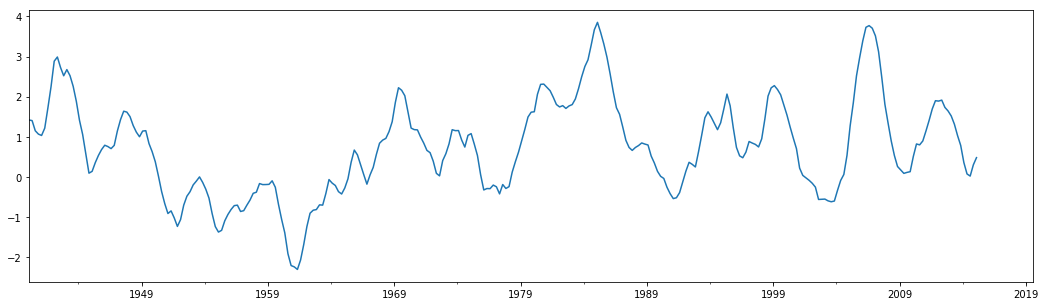

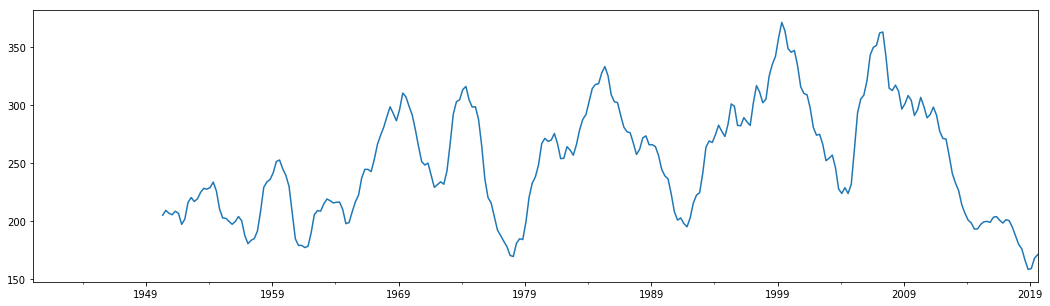

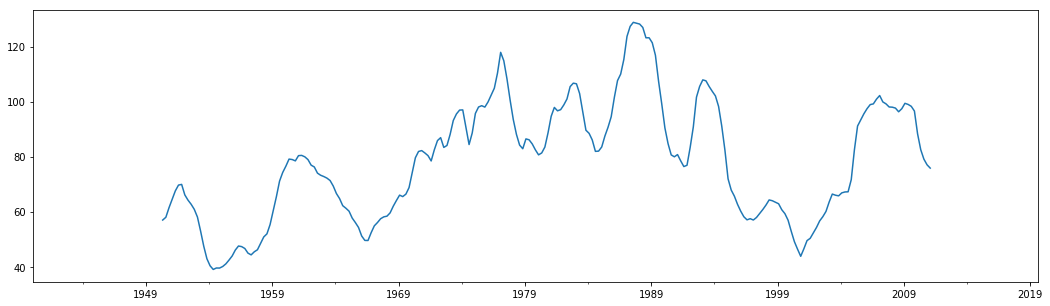

In [3]:
#This code includes a for loop to add the timeseries data for each well in the Cedar Valley Utah 
#aquifer which has dat from 1950 to 2015 and more than 20 samples of data
#these timeseries data are added to a pandas dataframe called combined_df 
with open('Cedar_Valley.json','r') as f:
    wells=json.load(f)
combined_df=pd.DataFrame()
mywells=[]
for well in wells['features']:
    if 'TsTime' in well:
        if len(well['TsTime'])>20:
            if np.array(well['TsTime']).max()>calendar.timegm(datetime.datetime(2015, 1, 1).timetuple()) and np.array(well['TsTime']).min()<calendar.timegm(datetime.datetime(1950, 1, 1).timetuple()):
                name = str(well['properties']['HydroID'])
                mywells.append(name)
                wells_df = pd.DataFrame(index=pd.to_datetime(well['TsTime'], unit='s', origin='unix'), data=well['TsValue'], columns=[name])
                wells_df = wells_df[np.logical_not(wells_df.index.duplicated())]
                try:
                    combined_df = pd.concat([combined_df, wells_df], join="outer", axis=1, sort=False)
                    combined_df.drop_duplicates(inplace=True)
                except Exception as e:
                    print(e)
                    break
#The data from the wells and the satellite observations are combined to a single dataframe (combined_df)
combined_df=pd.concat([combined_df,gldas_df], join="outer", axis=1, sort=False)
#The data are interpolated so that they are resampled to a monthy frequency
combined_df.interpolate(method='pchip', inplace=True, limit_area='inside')

start_date=1900
combined_df=combined_df.resample('3M').mean()
# decemb=combined_df.index.get_loc(str(start_date)+'-12-31 00:00:00',method='nearest') % 4
# combined_df=combined_df.iloc[decemb+1::4]

#plots to compare the 10 year mean of pdsi, soilw, and the observed water level at a well from 1940 on
combined_df['pdsi'].rolling(10).mean()['1940':].plot(figsize=(18,5))
plt.show()
combined_df['soilw'].rolling(10).mean()['1940':].plot(figsize=(18,5))
plt.show()
combined_df['soilm'].rolling(10).mean()['1940':].plot(figsize=(18,5))
plt.show()
#drop empty dates from the dataframe
#We now have monthy data from January 1958 to December 2014
combined_df=combined_df.dropna(axis=1,how='all')
combined_df.dropna(subset=names,inplace=True)
length=len(combined_df.columns)-1
combined_df2=combined_df.copy()

373236113111401
['pdsi_year1' 'pdsi_offset0.5' 'pdsi_offset0.25' 'pdsi_year1_offset0.25'
 'soilw_year1']
[0.44861598 0.43583898 0.42897865 0.35374361 0.32108743]


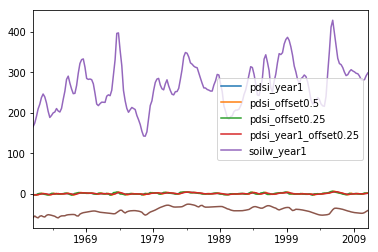

374105113085001
['soilw' 'soilw_offset2' 'soilm_offset3' 'soilw_offset0.75'
 'pdsi_offset0.25']
[0.16815649 0.16566728 0.14528436 0.14216113 0.13647219]


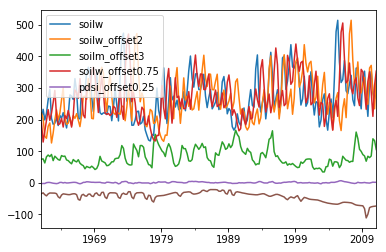

374132113063601
['soilw' 'soilw_offset0.75' 'soilw_offset1' 'pdsi_offset0.25' 'pdsi']
[0.33970277 0.22107049 0.19726433 0.1734796  0.16691076]


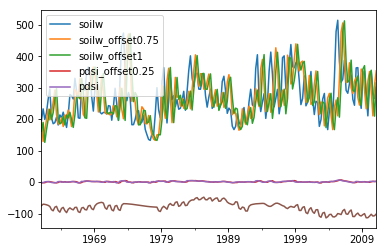

374304113052901
['pdsi_offset0.25' 'pdsi_year1' 'pdsi_offset0.5' 'soilw'
 'soilw_offset0.75']
[0.28264317 0.27424252 0.25487961 0.25445609 0.23653681]


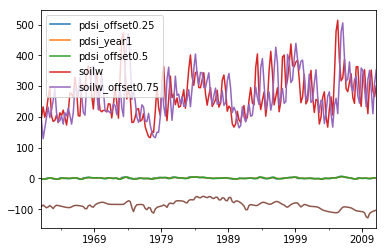

374423113053301
['pdsi_year1' 'pdsi_offset0.5' 'pdsi_offset0.25' 'pdsi_year1_offset0.25'
 'soilw_year1']
[0.43465672 0.42510251 0.39922649 0.37507249 0.32676925]


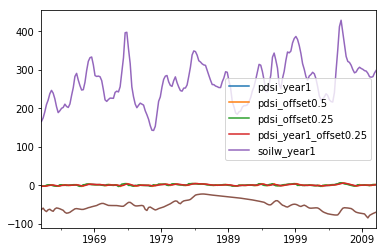

374927113033401
['soilw' 'soilw_offset0.75' 'soilw_year1' 'pdsi_offset0.5' 'soilw_offset1']
[0.28551361 0.19396761 0.1919581  0.18646691 0.18584578]


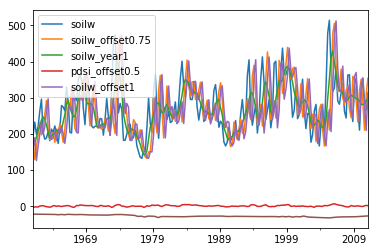

In [4]:
combined_df2[mywells]=combined_df2[mywells].diff()
corr_df=combined_df2.corr(min_periods=12).drop(mywells)
for i in range(0,len(mywells)):
    reflist=np.array(corr_df.nlargest(5,corr_df.columns[i]).index)
    corr_values=corr_df.nlargest(5, corr_df.columns[i]).values[:,i]
    print(corr_df.columns[i])
    print(reflist)
    print(corr_values)
    combined_df[reflist].plot()
    combined_df[corr_df.columns[i]].plot()
    plt.show()

Index([u'373236113111401', u'374105113085001', u'374132113063601',
       u'374304113052901', u'374423113053301', u'374927113033401', u'soilw',
       u'pdsi', u'soilm', u'pdsi_year1',
       ...
       u'soilw_year5_offset1.5', u'soilw_year5_offset2',
       u'soilw_year5_offset3', u'soilw_year10_offset0.25',
       u'soilw_year10_offset0.5', u'soilw_year10_offset0.75',
       u'soilw_year10_offset1', u'soilw_year10_offset1.5',
       u'soilw_year10_offset2', u'soilw_year10_offset3'],
      dtype='object', length=126)


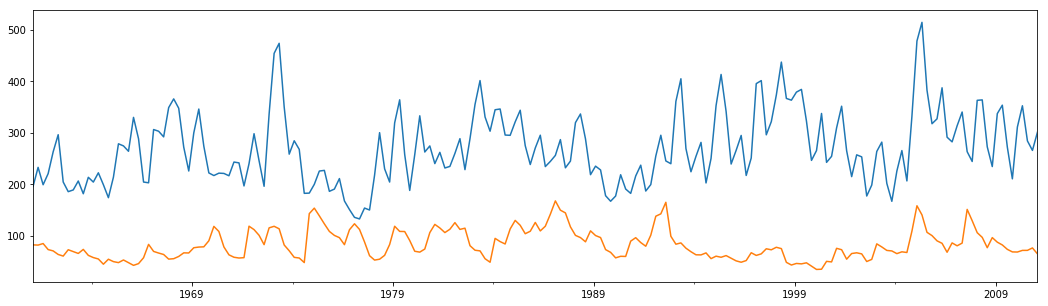

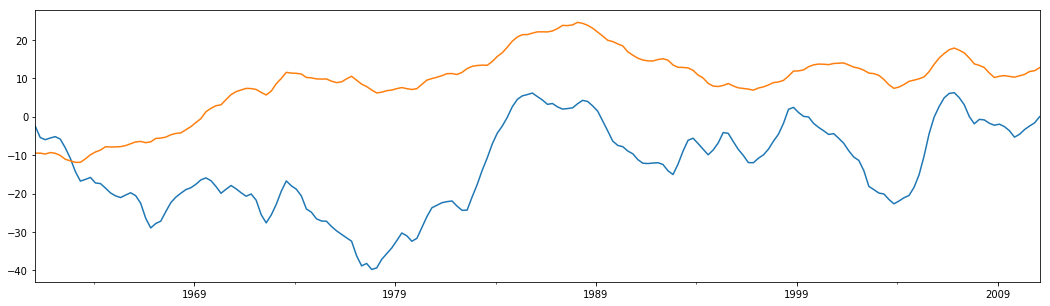

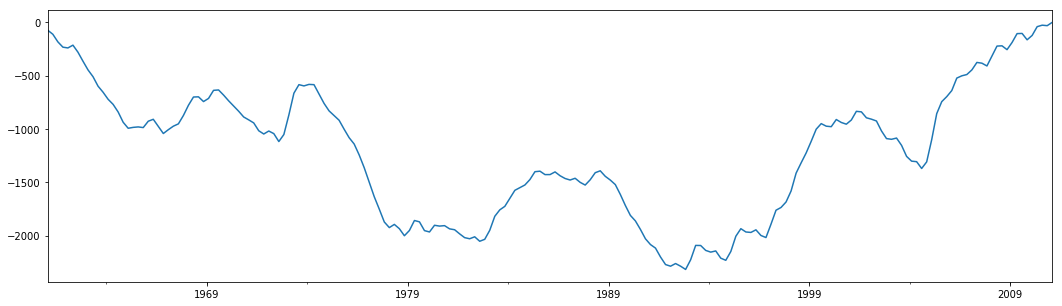

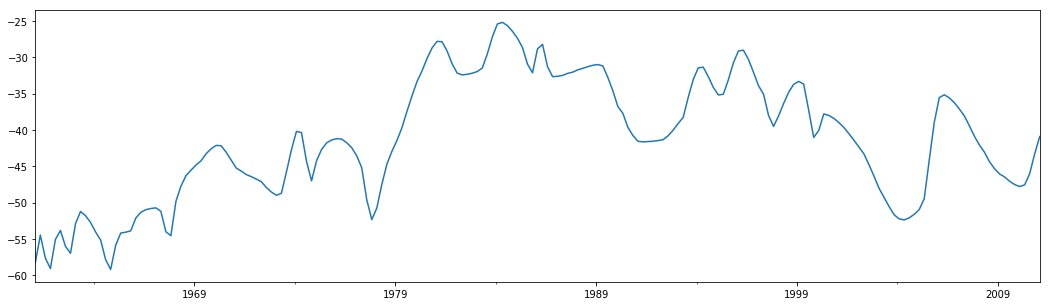

In [5]:
print(combined_df.columns)
combined_df['soilw'].plot(figsize=(18,5))
combined_df['soilm'].plot(figsize=(18,5))
plt.show()
# (combined_df['soilw']['1960':]-combined_df['soilw'].mean()).cumsum().plot(figsize=(18,5))
(combined_df['pdsi']['1960':]-combined_df['pdsi'].mean()).cumsum().plot(figsize=(18,5))
met=(combined_df['pdsi']['1960':]-combined_df['pdsi'].mean()).cumsum()
(combined_df['pdsi_year10']['1960':]*12).plot()
# (met-met.mean()).cumsum().plot(figsize=(18,5))
plt.show()
(combined_df['soilw']['1960':]-combined_df['soilw'].mean()).cumsum().plot(figsize=(18,5))
met=(combined_df['soilw']['1960':]-combined_df['soilw'].mean()).cumsum()
# (met-met.mean()).cumsum().plot(figsize=(18,5))
plt.show()
combined_df['373236113111401']['1960':].plot(figsize=(18,5))
plt.show()

In [6]:
date1='2000'
date2='2015'
combined_df['linear']=np.linspace(0,1,len(combined_df))
names.append('linear')
# The training period for this data is all dat up to 2000. In our case, 1958 to 2000 (42 years)
train_df=pd.concat([combined_df[:date1],combined_df[date2:]])
#the training data is normalized by subtracting the min and dividing by the range
#so that all the training data is now between 0 and 1
normed_train_x=(train_df-train_df.min())/(train_df.max()-train_df.min())
#all the data is normalized by subtracting the min and dividing by the range of the training dataset
normed_test_x=(combined_df-train_df.min())/(train_df.max()-train_df.min())
print("done")


done


373236113111401
Index([u'pdsi', u'soilm', u'soilw', u'pdsi_year1', u'pdsi_year3',
       u'pdsi_year5', u'pdsi_year10', u'soilm_year1', u'soilm_year3',
       u'soilm_year5',
       ...
       u'soilw_year5_offset2', u'soilw_year5_offset3',
       u'soilw_year10_offset0.25', u'soilw_year10_offset0.5',
       u'soilw_year10_offset0.75', u'soilw_year10_offset1',
       u'soilw_year10_offset1.5', u'soilw_year10_offset2',
       u'soilw_year10_offset3', u'linear'],
      dtype='object', length=121)
Input Weight shape: (122, 500)
(160, 500)
(500,)
Output weights shape: (500,)
(201, 500)


/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


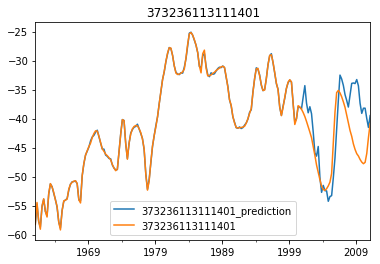

0.7407579422
374105113085001
Index([u'pdsi', u'soilm', u'soilw', u'pdsi_year1', u'pdsi_year3',
       u'pdsi_year5', u'pdsi_year10', u'soilm_year1', u'soilm_year3',
       u'soilm_year5',
       ...
       u'soilw_year5_offset2', u'soilw_year5_offset3',
       u'soilw_year10_offset0.25', u'soilw_year10_offset0.5',
       u'soilw_year10_offset0.75', u'soilw_year10_offset1',
       u'soilw_year10_offset1.5', u'soilw_year10_offset2',
       u'soilw_year10_offset3', u'linear'],
      dtype='object', length=121)
Input Weight shape: (122, 500)
(160, 500)
(500,)
Output weights shape: (500,)
(201, 500)


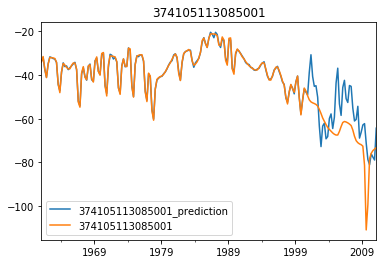

0.707889080048
374132113063601
Index([u'pdsi', u'soilm', u'soilw', u'pdsi_year1', u'pdsi_year3',
       u'pdsi_year5', u'pdsi_year10', u'soilm_year1', u'soilm_year3',
       u'soilm_year5',
       ...
       u'soilw_year5_offset2', u'soilw_year5_offset3',
       u'soilw_year10_offset0.25', u'soilw_year10_offset0.5',
       u'soilw_year10_offset0.75', u'soilw_year10_offset1',
       u'soilw_year10_offset1.5', u'soilw_year10_offset2',
       u'soilw_year10_offset3', u'linear'],
      dtype='object', length=121)
Input Weight shape: (122, 500)
(160, 500)
(500,)
Output weights shape: (500,)
(201, 500)


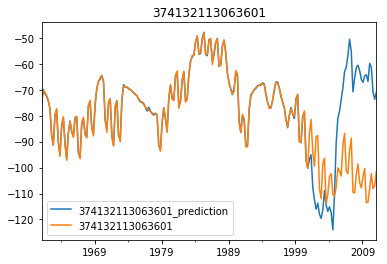

0.728575944901
374304113052901
Index([u'pdsi', u'soilm', u'soilw', u'pdsi_year1', u'pdsi_year3',
       u'pdsi_year5', u'pdsi_year10', u'soilm_year1', u'soilm_year3',
       u'soilm_year5',
       ...
       u'soilw_year5_offset2', u'soilw_year5_offset3',
       u'soilw_year10_offset0.25', u'soilw_year10_offset0.5',
       u'soilw_year10_offset0.75', u'soilw_year10_offset1',
       u'soilw_year10_offset1.5', u'soilw_year10_offset2',
       u'soilw_year10_offset3', u'linear'],
      dtype='object', length=121)
Input Weight shape: (122, 500)
(160, 500)
(500,)
Output weights shape: (500,)
(201, 500)


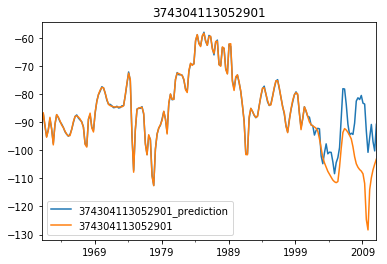

0.845767974854
374423113053301
Index([u'pdsi', u'soilm', u'soilw', u'pdsi_year1', u'pdsi_year3',
       u'pdsi_year5', u'pdsi_year10', u'soilm_year1', u'soilm_year3',
       u'soilm_year5',
       ...
       u'soilw_year5_offset2', u'soilw_year5_offset3',
       u'soilw_year10_offset0.25', u'soilw_year10_offset0.5',
       u'soilw_year10_offset0.75', u'soilw_year10_offset1',
       u'soilw_year10_offset1.5', u'soilw_year10_offset2',
       u'soilw_year10_offset3', u'linear'],
      dtype='object', length=121)
Input Weight shape: (122, 500)
(160, 500)
(500,)
Output weights shape: (500,)
(201, 500)


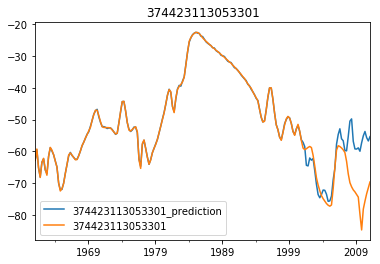

0.695004940033
374927113033401
Index([u'pdsi', u'soilm', u'soilw', u'pdsi_year1', u'pdsi_year3',
       u'pdsi_year5', u'pdsi_year10', u'soilm_year1', u'soilm_year3',
       u'soilm_year5',
       ...
       u'soilw_year5_offset2', u'soilw_year5_offset3',
       u'soilw_year10_offset0.25', u'soilw_year10_offset0.5',
       u'soilw_year10_offset0.75', u'soilw_year10_offset1',
       u'soilw_year10_offset1.5', u'soilw_year10_offset2',
       u'soilw_year10_offset3', u'linear'],
      dtype='object', length=121)
Input Weight shape: (122, 500)
(160, 500)
(500,)
Output weights shape: (500,)
(201, 500)


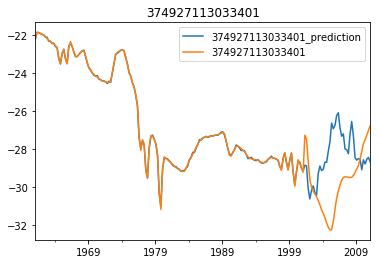

0.659744977951
time elapsed:  4.41666007042


In [7]:
pp = PdfPages('multipage.pdf')
st1=t.time()
#for each well in the dataframe, this loop uses the training data from 1958 to 2000 to fit a model for the timeseries
#using the Extreme Learning Machine Method
#After fitting the model, the model is used to predict the groudnwater levels in each well from 2000 to 2014
#The resulting timeseries are shown for each well.
#The actual data is in orange and the predicition is in blue
#All plots are also saved to a pdf called'multipage.pdf' so they can be easily accessed and viewed later

for well in mywells:
    start=t.time()
    thewell=[well]
    print(well)
    #The following lines separate out the training input values (tx) and output values (ty)
    #tx is a matrix of the monthly, yearly, 3-year, 5-year, and 10-year average values of soilw and pdsi
    #ty is a vector of the monthly average depth to water table value for the specified well
    normed_train_labels=normed_train_x[well]
    tx_df=normed_train_x[names]
    allx_df=normed_test_x[names]
    print(allx_df.columns)
#     print(names)
#     tx_df=normed_train_x.drop(thewell,axis=1)
#     allx_df=normed_test_x.drop(thewell,axis=1)
    tx=tx_df.values
    x1=np.column_stack(np.ones(tx.shape[0])).T
    tx=np.hstack((tx,x1))
    ty=normed_train_labels.values
    INPUT_LENGTH=tx.shape[1]
    HIDDEN_UNITS=500
    lamb=1
    Win=np.random.normal(size=[INPUT_LENGTH, HIDDEN_UNITS])
    b=np.random.normal(size=[HIDDEN_UNITS])
    print('Input Weight shape: {shape}'.format(shape=Win.shape))
    def input_to_hidden(x):
        a=np.dot(x,Win)+b
        print(a.shape)
        a=np.maximum(a,0,a)#relu
        return a
    X=input_to_hidden(tx)
    Xt=np.transpose(X)
    I=np.identity(X.shape[1])
#     I[X.shape[1]-1,X.shape[1]-1]=0
    Wout=np.linalg.lstsq(X.T.dot(X) + lamb * I, X.T.dot(ty))[0]
    print(Wout.shape)
    print('Output weights shape: {shape}'.format(shape=Wout.shape))
    def predict(x):
        x=input_to_hidden(x)
        y=np.dot(x,Wout)
        return y
    allx=allx_df.values
    A1=np.column_stack(np.ones(allx.shape[0])).T
    allx=np.hstack((allx,A1))
    test_predictions=predict(allx)
    
    prediction=str(well)+"_prediction"

    
    combined_df[prediction]=test_predictions
    combined_df[prediction]=combined_df[prediction]*(train_df[well].max()-train_df[well].min())+train_df[well].min()
    combined_df[[prediction,well]].plot()
    plt.title(well)
    plt.legend()
    pp.savefig()
    plt.show()
    plt.close()
    print(t.time()-start)
pp.close()
print("time elapsed: ",t.time()-st1)

159


/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


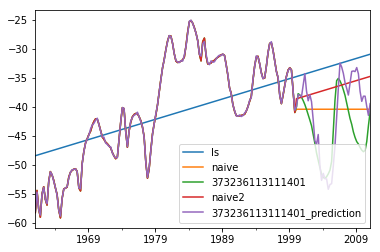

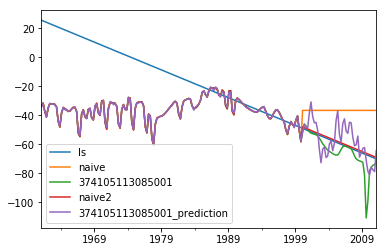

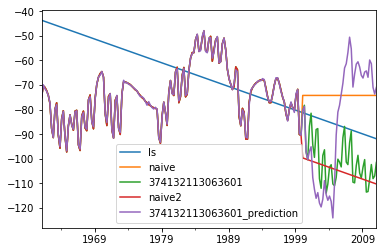

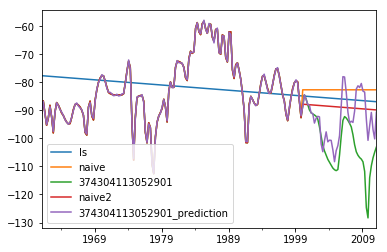

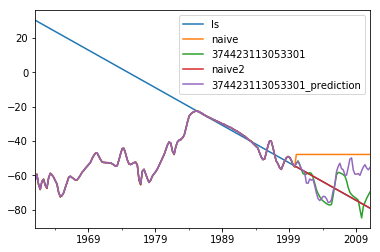

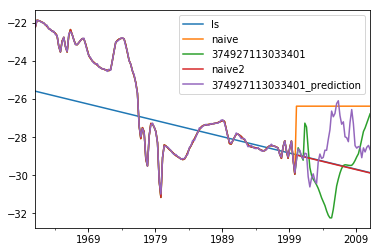

                 training   testing  least squares     naive   lsnaive
373236113111401  0.004947  0.337392       0.731298  0.367148  0.536069
374105113085001  0.012007  0.230404       0.170477  0.541058  0.181208
374132113063601  0.009088  0.935374       0.510946  0.884804  0.261258
374304113052901  0.005749  0.362328       0.500595  0.581718  0.433814
374423113053301  0.003593  0.414983       0.272473  0.833608  0.272542
374927113033401  0.004751  0.446576       0.300590  0.664144  0.300144
1  regularization: 0.4545094496647706


In [8]:
import HydroErr as he
import statsmodels.api as sm
training_set=combined_df.loc[train_df.index]
testing_set=combined_df.drop(train_df.index)
tr_errors=[]
te_errors=[]
tls_errors=[]
naive_errors=[]
combined_errors=[]
date1='2000'
sdate='1990'
naive_date=combined_df.index.get_loc(str(date1)+'-12-31 00:00:00',method='nearest')
print(naive_date)
for well in mywells:
    prediction=str(well)+"_prediction"
    combined_df['naive']=combined_df[well]
    combined_df['naive'][date1:]=combined_df[well][:date1].mean()
    model = sm.OLS(combined_df[well][sdate:date1], sm.add_constant(combined_df['linear'][sdate:date1])).fit()
    b,a=model.params
    combined_df['ls']=a*combined_df['linear']+b
    combined_df['naive2']=combined_df[well]
    combined_df['naive2'][date1:]=combined_df['ls'][date1:]-combined_df['ls'][naive_date]+combined_df[well][naive_date]
    combined_df[['ls','naive',well,'naive2',prediction]].plot()
    plt.show()
    training_set=combined_df.loc[train_df.index]
    testing_set=combined_df.drop(train_df.index)
    d=he.nrmse_range(training_set[prediction],training_set[well])
    tr_errors.append(d)
    d=he.nrmse_range(testing_set[prediction],testing_set[well])
    te_errors.append(d)
    d=he.nrmse_range(testing_set['ls'],testing_set[well])
    tls_errors.append(d)
    d=he.nrmse_range(testing_set['naive'],testing_set[well])
    naive_errors.append(d)
    d=he.nrmse_range(testing_set['naive2'],testing_set[well])
    combined_errors.append(d)
errors=np.column_stack((tr_errors,te_errors,tls_errors,naive_errors,combined_errors))
error_df=pd.DataFrame(index=mywells,columns=['training','testing','least squares','naive','lsnaive'],data=errors)
error=error_df['testing'].mean()
print(error_df)
print(str(lamb)," regularization:", error)